In [2]:
%reset -f
import os, math
import numpy as np
seed = 2018
np.random.seed(seed)
import librosa
from collections import Counter
from sklearn import manifold
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.layers import Input
from keras import Model
from keras import backend as K
from keras.utils import np_utils
import soundfile as sf
from keras.applications.densenet import DenseNet121
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.layers import Input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from wavhandler import *
from utils_train import *

ERROR:root:Invalid alias: The name clear can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name more can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name less can't be aliased because it is another magic command.
ERROR:root:Invalid alias: The name man can't be aliased because it is another magic command.
Using TensorFlow backend.


In [3]:
model_name = './temp_data/mosquitoes_raw'
if model_name.split('/')[-1].split('_')[0] == 'mosquitoes':
    mosquitoes = True
    data = Dataset('Wingbeats')
    data.read(data='all', setting='read', labels='text', loadmat=False)
    target_names = data.target_classes
else:
    mosquitoes = False
    data1 = Dataset('Leafminers')
    data1.read(data=data1.target_classes[0], setting='read', loadmat=False, labels='text')

    data2 = Dataset('LG')
    data2.read(data=data2.target_classes[0], setting='read', loadmat=False, labels='text')

    data3 = Dataset('LG')
    data3.read(data=data3.target_classes[1], setting='read', loadmat=False, labels='text')

    data4 = Dataset('Pcfruit')
    data4.read(data=data4.target_classes[1], setting='read', loadmat=False, labels='text')

    # data1.clean(plot=False)
    # data2.clean(plot=False)
    # data3.clean(plot=False)
    # data4.clean(plot=False)

    data = pd.DataFrame()
    data['filenames'] = pd.concat([data1.filenames, data2.filenames, data3.filenames, data4.filenames], axis=0).reset_index(drop=True)
    data['y'] = data.filenames.apply(lambda x: x.split('/')[6])

    target_names = data.y.unique().tolist()

if model_name.split('/')[-1].split('_')[1] == 'spec':
    setting = 'stft'
    layer = -2
else:
    setting = 'raw'
    layer = -3
    
current_model = DenseNet121
best_weights_path = model_name + '.h5'
valid_features_file = model_name + 'valid_features.npy'
valid_labels_file = model_name + "_" + 'valid_labels.npy'
batch_size = 32
input_shape = (5000,1)#(129, 120, 1)

Data: all.
Read 279566 filenames in 0.82 seconds.


In [4]:
X, y = data.filenames.tolist(), data.y.tolist()

y = LabelEncoder().fit_transform(y)
# X = X_names#np.array(X_names).reshape(-1,1)

X, y = shuffle(X, y, random_state=0) 

X_train, X_test, X_val, y_train, y_test, y_val = train_test_val_split(X,y, random_state=0)

In [5]:
img_input = Input(shape = input_shape)

# model = current_model(input_tensor = img_input, classes = len(target_names), weights = None)
from keras.models import model_from_yaml
yaml_file = open(model_name + '.yaml', 'r')
model_yaml = yaml_file.read()
yaml_file.close()
model = model_from_yaml(model_yaml)

x_new = model.layers[layer].output

In [6]:
# Load pretrained weights. You can get them after running the code in the following link https://www.kaggle.com/left13/various-nets-densenet121-0-96-acc-full-set
model.load_weights(best_weights_path)

In [7]:
model = Model(model.layers[0].input, x_new, name = 'test')

model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy']) 

In [8]:
valid_features = model.predict_generator(valid_generator(X_test, 
                                                    y_test, 
                                                    batch_size=32, 
                                                    setting=setting, 
                                                    target_names=data.y.unique().tolist()),
        steps = int(math.ceil(float(len(X_test)) / float(32))))

In [9]:
if not os.path.exists(valid_features_file):
    np.save(open(valid_features_file, 'wb'), valid_features)
if not os.path.exists(valid_labels_file):
    np.save(valid_labels_file, y_test)

XX = np.load(valid_features_file)
y = np.load(valid_labels_file)

tsne = manifold.TSNE(n_components = 2, perplexity = 30, init='pca',random_state = seed, verbose = 1)
X = tsne.fit_transform(np.vstack(XX))

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 27957 samples in 0.480s...
[t-SNE] Computed neighbors for 27957 samples in 132.398s...
[t-SNE] Computed conditional probabilities for sample 1000 / 27957
[t-SNE] Computed conditional probabilities for sample 2000 / 27957
[t-SNE] Computed conditional probabilities for sample 3000 / 27957
[t-SNE] Computed conditional probabilities for sample 4000 / 27957
[t-SNE] Computed conditional probabilities for sample 5000 / 27957
[t-SNE] Computed conditional probabilities for sample 6000 / 27957
[t-SNE] Computed conditional probabilities for sample 7000 / 27957
[t-SNE] Computed conditional probabilities for sample 8000 / 27957
[t-SNE] Computed conditional probabilities for sample 9000 / 27957
[t-SNE] Computed conditional probabilities for sample 10000 / 27957
[t-SNE] Computed conditional probabilities for sample 11000 / 27957
[t-SNE] Computed conditional probabilities for sample 12000 / 27957
[t-SNE] Computed conditional probabilities for s

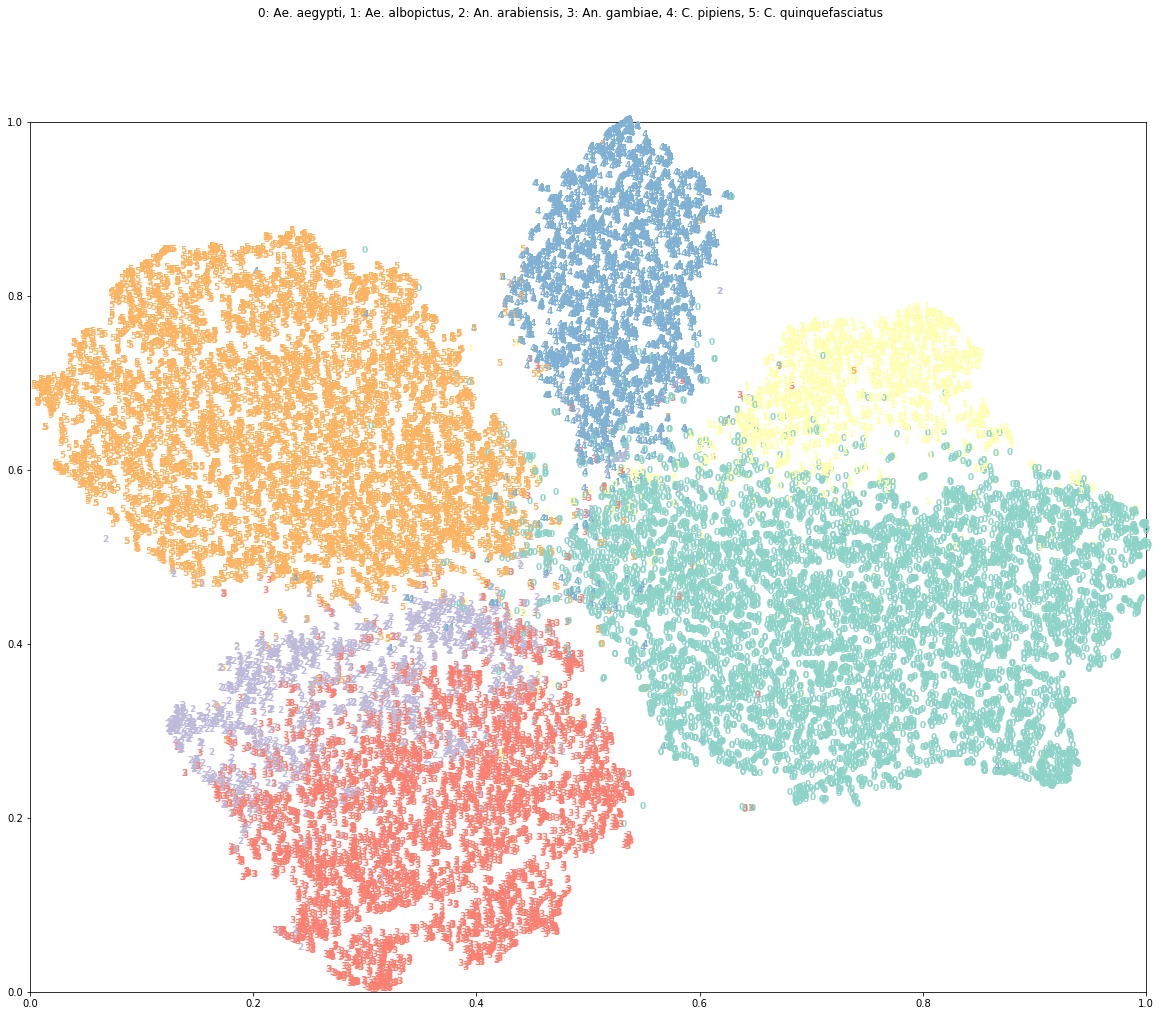

In [13]:
if not os.path.exists(model_name + "_" + 'tsne.npy'):
    np.save( model_name + "_" + 'tsne.npy', X)

fig = plt.figure(figsize = (2*10, 2*8))
ax = fig.gca()

x_min, x_max = np.min(X, 0), np.max(X, 0)
X = (X - x_min) / (x_max - x_min)

for i in range(X.shape[0]):
    ax.text(X[i, 0], X[i, 1], str(y[i]), color = plt.cm.Set3(y[i]), fontdict = {'weight': 'bold', 'size': 9})

if mosquitoes:
    suptitle = '0: Ae. aegypti, 1: Ae. albopictus, 2: An. arabiensis, 3: An. gambiae, 4: C. pipiens, 5: C. quinquefasciatus'
else:
    suptitle = '0: Cichorii, 1: Suzukii, 2: Melanogaster, 3: Zaprionus'
fig.suptitle(suptitle)

plt.show()

In [11]:
pd.Series(y).value_counts()

0    8555
5    7460
3    4947
4    3042
1    2023
2    1930
dtype: int64

In [12]:
data.y.value_counts()

Ae. aegypti            85553
C. quinquefasciatus    74599
An. gambiae            49471
C. pipiens             30415
Ae. albopictus         20231
An. arabiensis         19297
dtype: int64